<a href="https://colab.research.google.com/github/geopan2000/Exploring-Mental-Health-Data/blob/main/Mental-Health-Data4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
# Clone the GitHub repository
!git clone https://github.com/geopan2000/Exploring-Mental-Health-Data.git

# Change directory to the cloned repository
%cd Exploring-Mental-Health-Data

Cloning into 'Exploring-Mental-Health-Data'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 66 (delta 27), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 5.52 MiB | 3.93 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/Exploring-Mental-Health-Data/Exploring-Mental-Health-Data/Exploring-Mental-Health-Data/Exploring-Mental-Health-Data/Exploring-Mental-Health-Data/Exploring-Mental-Health-Data


In [118]:
import pandas as pd
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost as xgb
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

In [119]:
train_set = pd.read_csv('/content/Exploring-Mental-Health-Data/data/train.csv')
test_set = pd.read_csv('/content/Exploring-Mental-Health-Data/data/test.csv')

In [120]:
train_set.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


# Feature Engineering:


In [121]:
train_id = train_set['id']

target_variable = train_set['Depression']
train_set.drop(columns=['id','Name','Depression'], inplace=True)
test_id = test_set['id']

test_set.drop(columns=['id','Name'], inplace=True)

train_set['Gender'] = train_set['Gender'].map({'Male' : 1, 'Female' : 0}) # Always trasnforming 2 option object types into binary
test_set['Gender'] = test_set['Gender'].map({'Male' : 1, 'Female' : 0})

train_set['Age'] = train_set['Age'] / 100 # Normalized by the Max value
train_set['Age'] = train_set['Age'].fillna(train_set['Age'].mean())
test_set['Age'] = test_set['Age'] / 100
test_set['Age'] = test_set['Age'].fillna(test_set['Age'].mean())

train_set['Working Professional or Student'] = train_set['Working Professional or Student'].map({'Working Professional' : 1, 'Student' : 0}) # Always trasnforming 2 option object types into binary
test_set['Working Professional or Student'] = test_set['Working Professional or Student'].map({'Working Professional' : 1, 'Student' : 0})

train_set['CGPA'] = train_set['CGPA'] /10
train_set['CGPA'] = train_set['CGPA'].fillna(0)
test_set['CGPA'] = test_set['CGPA'] /10
test_set['CGPA'] = test_set['CGPA'].fillna(0)

train_set['Have you ever had suicidal thoughts ?'] = train_set['Have you ever had suicidal thoughts ?'].map({'Yes' : 1, 'No' : 0}) # Always trasnforming 2 option object types into binary
test_set['Have you ever had suicidal thoughts ?'] = test_set['Have you ever had suicidal thoughts ?'].map({'Yes' : 1, 'No' : 0})

train_set['Work/Study Hours'] = train_set['Work/Study Hours'] / 24 # Normalized by the Max value
test_set['Work/Study Hours'] = test_set['Work/Study Hours'] / 24

train_set['Financial Stress'] = train_set['Financial Stress'] / 5 # Normalized by the Max value
train_set['Financial Stress'] = train_set['Financial Stress'].fillna(0)
test_set['Financial Stress'] = test_set['Financial Stress'] / 5
test_set['Financial Stress'] = test_set['Financial Stress'].fillna(0)

train_set['Family History of Mental Illness'] = train_set['Family History of Mental Illness'].map({'Yes' : 1, 'No' : 0}) # Always trasnforming 2 option object types into binary
test_set['Family History of Mental Illness'] = test_set['Family History of Mental Illness'].map({'Yes' : 1, 'No' : 0})

In [122]:
# Create the new feature 'Academic/Work Pressure'
train_set['Academic/Work Pressure'] = train_set.apply(
    lambda row: row['Academic Pressure'] if pd.notna(row['Academic Pressure']) and pd.isna(row['Work Pressure']) else
                row['Work Pressure'] if pd.isna(row['Academic Pressure']) and pd.notna(row['Work Pressure']) else
                (row['Academic Pressure'] + row['Work Pressure']) / 2 if pd.notna(row['Academic Pressure']) and pd.notna(row['Work Pressure']) else
                None,  # Placeholder for rows where both are NaN
    axis=1)

# Fill any remaining NaN in 'Academic/Work Pressure' with its mean
train_set['Academic/Work Pressure'] = train_set['Academic/Work Pressure'].fillna(train_set['Academic/Work Pressure'].mean())

train_set['Academic Pressure'] = train_set['Academic Pressure'] / 5
train_set['Academic Pressure'] = train_set['Academic Pressure'].fillna(0)

train_set['Work Pressure'] = train_set['Work Pressure'] / 5
train_set['Work Pressure'] = train_set['Work Pressure'].fillna(0)

In [123]:
# Create the new feature 'Academic/Work Pressure'
test_set['Academic/Work Pressure'] = test_set.apply(
    lambda row: row['Academic Pressure'] if pd.notna(row['Academic Pressure']) and pd.isna(row['Work Pressure']) else
                row['Work Pressure'] if pd.isna(row['Academic Pressure']) and pd.notna(row['Work Pressure']) else
                (row['Academic Pressure'] + row['Work Pressure']) / 2 if pd.notna(row['Academic Pressure']) and pd.notna(row['Work Pressure']) else
                None,  # Placeholder for rows where both are NaN
    axis=1)

# Fill any remaining NaN in 'Academic/Work Pressure' with its mean
test_set['Academic/Work Pressure'] = test_set['Academic/Work Pressure'].fillna(test_set['Academic/Work Pressure'].mean())

test_set['Academic Pressure'] = test_set['Academic Pressure'] / 5
test_set['Academic Pressure'] = test_set['Academic Pressure'].fillna(0)

test_set['Work Pressure'] = test_set['Work Pressure'] / 5
test_set['Work Pressure'] = test_set['Work Pressure'].fillna(0)

In [124]:
# Create the new feature Study/Job Satisfaction
train_set['Study/Job Satisfaction'] = train_set.apply(
    lambda row: row['Study Satisfaction'] if pd.notna(row['Study Satisfaction']) and pd.isna(row['Job Satisfaction']) else
                row['Job Satisfaction'] if pd.isna(row['Study Satisfaction']) and pd.notna(row['Job Satisfaction']) else
                (row['Study Satisfaction'] + row['Job Satisfaction']) / 2 if pd.notna(row['Study Satisfaction']) and pd.notna(row['Job Satisfaction']) else
                None,  # Placeholder for rows where both are NaN
    axis=1)

# Fill any remaining NaN in Study/Job Satisfaction with its mean
train_set['Study/Job Satisfaction'] = train_set['Study/Job Satisfaction'].fillna(train_set['Study/Job Satisfaction'].mean())

train_set['Study Satisfaction'] = train_set['Study Satisfaction'] / 5
train_set['Study Satisfaction'] = train_set['Study Satisfaction'].fillna(0)

train_set['Job Satisfaction'] = train_set['Job Satisfaction'] / 5
train_set['Job Satisfaction'] = train_set['Job Satisfaction'].fillna(0)

In [125]:
# Create the new feature Study/Job Satisfaction
test_set['Study/Job Satisfaction'] = test_set.apply(
    lambda row: row['Study Satisfaction'] if pd.notna(row['Study Satisfaction']) and pd.isna(row['Job Satisfaction']) else
                row['Job Satisfaction'] if pd.isna(row['Study Satisfaction']) and pd.notna(row['Job Satisfaction']) else
                (row['Study Satisfaction'] + row['Job Satisfaction']) / 2 if pd.notna(row['Study Satisfaction']) and pd.notna(row['Job Satisfaction']) else
                None,  # Placeholder for rows where both are NaN
    axis=1)

# Fill any remaining NaN in Study/Job Satisfaction with its mean
test_set['Study/Job Satisfaction'] = test_set['Study/Job Satisfaction'].fillna(test_set['Study/Job Satisfaction'].mean())

test_set['Study Satisfaction'] = test_set['Study Satisfaction'] / 5
test_set['Study Satisfaction'] = test_set['Study Satisfaction'].fillna(0)

test_set['Job Satisfaction'] = test_set['Job Satisfaction'] / 5
test_set['Job Satisfaction'] = test_set['Job Satisfaction'].fillna(0)

In [126]:
# Combine train and test value counts
train_counts = train_set['City'].value_counts()
test_counts = test_set['City'].value_counts()

# Create a combined count of professions
combined_counts = train_counts.add(test_counts, fill_value=0)

# Identify professions appearing less than 5 times in either set
low_frequency_values = combined_counts[combined_counts < 10].index.tolist()

# Map low-frequency values to 'None' in both train and test sets
train_set['City'] = train_set['City'].apply(lambda x: 'Other' if x in low_frequency_values else x)
test_set['City'] = test_set['City'].apply(lambda x: 'Other' if x in low_frequency_values else x)

In [127]:
# Combine train and test value counts
train_counts = train_set['Profession'].value_counts()
test_counts = test_set['Profession'].value_counts()

# Create a combined count of professions
combined_counts = train_counts.add(test_counts, fill_value=0)

# Identify professions appearing less than 5 times in either set
low_frequency_values = combined_counts[combined_counts < 10].index.tolist()

# Map low-frequency values to 'None' in both train and test sets
train_set['Profession'] = train_set['Profession'].apply(lambda x: 'Other' if x in low_frequency_values else x)
test_set['Profession'] = test_set['Profession'].apply(lambda x: 'Other' if x in low_frequency_values else x)

In [128]:
# Combine train and test value counts
train_counts = train_set['Degree'].value_counts()
test_counts = test_set['Degree'].value_counts()

# Create a combined count of professions
combined_counts = train_counts.add(test_counts, fill_value=0)

# Identify professions appearing less than 5 times in either set
low_frequency_values = combined_counts[combined_counts < 10].index.tolist()

# Map low-frequency values to 'None' in both train and test sets
train_set['Degree'] = train_set['Degree'].apply(lambda x: 'Other' if x in low_frequency_values else x)
test_set['Degree'] = test_set['Degree'].apply(lambda x: 'Other' if x in low_frequency_values else x)

In [129]:
train_set['City'] = train_set['City'].fillna('Other')
freq = train_set['City'].value_counts()
train_set['City_freq'] = train_set['City'].map(freq) # Frequency encoding different cities

test_set['City'] = test_set['City'].fillna('Other')
test_set['City_freq'] = test_set['City'].map(freq) # Frequency encoding different cities


train_set['Degree'] = train_set['Degree'].fillna('Other')
freq = train_set['Degree'].value_counts()
train_set['Degree_freq'] = train_set['Degree'].map(freq) # Frequency encoding

test_set['Degree'] = test_set['Degree'].fillna('Other')
test_set['Degree_freq'] = test_set['Degree'].map(freq) # Frequency encoding


train_set['Profession'] = train_set['Profession'].fillna('Other')
freq = train_set['Profession'].value_counts()
train_set['Profession_freq'] = train_set['Profession'].map(freq) # Frequency encoding

test_set['Profession'] = test_set['Profession'].fillna('Other')
test_set['Profession_freq'] = test_set['Profession'].map(freq) # Frequency encoding

In [130]:
# Save the original number of rows for splitting later
train_size = len(train_set)

# Concatenate train and test sets
concat_set = pd.concat([train_set, test_set], axis=0)

# Apply one-hot encoding to the concatenated set
concat_set = pd.get_dummies(concat_set, columns=['Degree', 'Profession', 'City'])

# Split the concatenated set back into train and test sets
train_set = concat_set.iloc[:train_size, :].copy()  # Get the original train rows
test_set = concat_set.iloc[train_size:, :].copy()   # Get the original test rows

print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)

Train set shape: (140700, 116)
Test set shape: (93800, 116)


In [131]:
 #Define a function to encode Sleep Duration
def encode_sleep_duration(value):
    # Check for NaN or None
    if pd.isna(value):
        return -1  # Placeholder for missing or invalid values

    # Ensure the value is a string
    value = str(value).strip()

    # Encoding logic
    if 'Less than 5 hours' in value or value in ['3-4 hours', '4-5 hours', '2-3 hours']:
        return 1  # < 5 hours
    elif '5-6 hours' in value:
        return 2  # 5-6 hours
    elif '6-7 hours' in value or '6-8 hours' in value:
        return 3  # 6-7 hours
    elif '7-8 hours' in value:
        return 4  # 7-8 hours
    elif 'More than 8 hours' in value or '8-9 hours' in value or '9-11 hours' in value:
        return 5  # > 8 hours
    else:
        return -1  # Placeholder for other invalid or unclear values

sleep_mapping = {
    'More than 8 hours': '>8',
    'Less than 5 hours': '<5',
    'Moderate': '5-6 hours',
    '9-6 hours': '6-9 hours',

    '10-6 hours': '6-10 hours',
    'than 5 hours': '4-6 hours',
    'Unhealthy': '4-6 hours',
    '9-5 hours': '5-9 hours',
    '9-5': '5-9 hours',
    '8-89 hours': '8-9 hours',

    # Ambiguous or irrelevant entries
    'Sleep_Duration': None, '40-45 hours': None, '55-66 hours': None, 'Indore': None,
    '45': None, '35-36 hours': None, 'No': None, 'Indore': None, '49 hours': None,
    'Work_Study_Hours': None, '45-48 hours': None, 'Pune': None, 'Soham': None,
    '0': None, 'Meerut': None, '60-65 hours': None, 'Vivan': None,
    'Have_you_ever_had_suicidal_thoughts': None, '20-21 hours': None, '50-75 hours': None
}

# Define range extraction function
def extract_range(value):
    try:
        if '-' in value:
            parts = value.split('-')
            return int(parts[0]), int(parts[1].split()[0])
        elif '<' in value:
            return 3, 5
        elif '>' in value:
            lower_bound = int(value.split('>')[1].split()[0])
            return lower_bound, 10
        elif value.isdigit():
            num = int(value)
            return num, num
        else:
            return None, None
    except:
        return None, None

In [132]:
train_set['Sleep Duration'] = train_set['Sleep Duration'].map(sleep_mapping)
test_set['Sleep Duration'] = test_set['Sleep Duration'].map(sleep_mapping)

train_set['Sleep_Duration_Encoded'] = train_set['Sleep Duration'].apply(encode_sleep_duration)
test_set['Sleep_Duration_Encoded'] = test_set['Sleep Duration'].apply(encode_sleep_duration)

# Apply the function to create 'From' and 'To' columns
train_set[['From', 'To']] = train_set['Sleep Duration'].apply(lambda x: pd.Series(extract_range(x)))
test_set[['From', 'To']] = test_set['Sleep Duration'].apply(lambda x: pd.Series(extract_range(x)))

# Handle missing values
train_set['From'] = train_set['From'].fillna(train_set['From'].mean())
train_set['To'] = train_set['To'].fillna(train_set['To'].mean())

test_set['From'] = test_set['From'].fillna(test_set['From'].mean())
test_set['To'] = test_set['To'].fillna(test_set['To'].mean())

# Drop the original column if not needed
train_set.drop(columns=['Sleep Duration'], inplace=True)
test_set.drop(columns=['Sleep Duration'], inplace=True)

In [133]:
print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)

Train set shape: (140700, 118)
Test set shape: (93800, 118)


In [134]:
# Define mapping for valid dietary habits
dietary_mapping = {
    'Moderate': 'Moderate',
    'Unhealthy': 'Unhealthy',
    'Healthy': 'Healthy',
    'More Healthy': 'Healthy',
    'Less Healthy': 'Unhealthy',
    'Less than Healthy': 'Unhealthy',
    'No Healthy': 'Unhealthy',
    '3': 'Moderate',
    '1.0': 'Unhealthy',
    '2': 'Moderate',
    '5 Healthy': 'Healthy',
    '5 Unhealthy': 'Unhealthy',

    # Ambiguous or irrelevant entries
    'Yes': None, 'No': None, 'No Healthy': None, 'Class 12': None, 'Indoor': None,
    'Male': None, 'Vegas': None, 'M.Tech': None, 'Electrician': None,
    'Hormonal': None, 'Mihir': None, 'Gender': None, 'BSc': None,
    'Pratham': None, 'Prachi': None, 'Resistant': None, 'Mealy': None,

    'nan': None, 'Academic': None, 'Educational': None, 'Soham': None,
    'Naina': None, 'Kolkata': None, 'Raghav': None, 'Vivaan': None,  'MCA': None,
}

# Apply the mapping to the Dietary Habits column
train_set['Dietary Habits'] = train_set['Dietary Habits'].map(dietary_mapping)
train_set['Dietary Habits'] = train_set['Dietary Habits'].fillna('X')

test_set['Dietary Habits'] = test_set['Dietary Habits'].map(dietary_mapping)
test_set['Dietary Habits'] = test_set['Dietary Habits'].fillna('X')

freq = train_set['Dietary Habits'].value_counts()
train_set['Dietary Habits_freq'] = train_set['Dietary Habits'].map(freq) # frequency encoding
test_set['Dietary Habits_freq'] = test_set['Dietary Habits'].map(freq) # frequency encoding

# Save the original number of rows for splitting later
train_size = len(train_set)

# Concatenate train and test sets
concat_set = pd.concat([train_set, test_set], axis=0)

# Apply one-hot encoding to the concatenated set
concat_set = pd.get_dummies(concat_set, columns=['Dietary Habits'])

# Split the concatenated set back into train and test sets
train_set = concat_set.iloc[:train_size, :].copy()  # Get the original train rows
test_set = concat_set.iloc[train_size:, :].copy()   # Get the original test rows

In [135]:
print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)

Train set shape: (140700, 122)
Test set shape: (93800, 122)


# Last Check before tuning

In [136]:
# Check for columns with object data type in train_set and test_set
train_object_columns = train_set.select_dtypes(include=['object']).columns
test_object_columns = test_set.select_dtypes(include=['object']).columns

print("Object columns in train_set:", train_object_columns.tolist())
print("Object columns in test_set:", test_object_columns.tolist())

# Check for columns with missing values in train_set and test_set
train_missing = train_set.isna().sum()
test_missing = test_set.isna().sum()

print("\nColumns with missing values in train_set:")
print(train_missing[train_missing > 0])

print("\nColumns with missing values in test_set:")
print(test_missing[test_missing > 0])


Object columns in train_set: []
Object columns in test_set: []

Columns with missing values in train_set:
Series([], dtype: int64)

Columns with missing values in test_set:
Series([], dtype: int64)


# Create a validation set

In [138]:
X = train_set.copy()
y = target_variable

# Initial split for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.07, stratify=y, random_state=42)

# Print the count of True and False in both train and validation sets
print("Training set class distribution:\n", y_train.value_counts())
print("Validation set class distribution:\n", y_val.value_counts())

Training set class distribution:
 Depression
0    107073
1     23777
Name: count, dtype: int64
Validation set class distribution:
 Depression
0    8060
1    1790
Name: count, dtype: int64


In [139]:
# Define parameter search space
search_spaces = {
    'learning_rate': Real(0.0001, 0.5, 'uniform'),
    'max_depth': Integer(2, 200),
    'n_estimators': Integer(100, 1000),
}

# Initialize the XGBClassifier model with GPU support
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Use for binary classification
    tree_method='hist',  # Use GPU for training
    verbosity=2
)

kf = KFold(n_splits=3)  # 5-fold cross-validation

# Use 'accuracy' as the scoring metric
optimizer = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=64,
    cv=kf,
    scoring='accuracy',  # Change scoring metric to accuracy
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Fit the optimizer using X_train and y_train
optimizer.fit(X_train, y_train)

# Get cross-validation results
cv_results = optimizer.cv_results_

# Create a DataFrame to sort and filter the best models
results_df = pd.DataFrame(cv_results)
top_5_results = results_df.nlargest(5, 'mean_test_score')  # Get top 5 models by mean test score

# Train each of the top 5 models on the full training data and save them
top_5_models = []
for i, row in top_5_results.iterrows():
    params = row['params']
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        tree_method='hist',
        **params
    )
    model.fit(X_train, y_train)
    top_5_models.append(model)

# Print parameters and scores for the top 5 models
for idx, model in enumerate(top_5_models):
    print(f"Model {idx + 1} parameters: {top_5_results.iloc[idx]['params']}")
    print(f"Model {idx + 1} CV score: {top_5_results.iloc[idx]['mean_test_score']}")

print("Top 5 XGBoost models based on accuracy have been trained and saved.")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

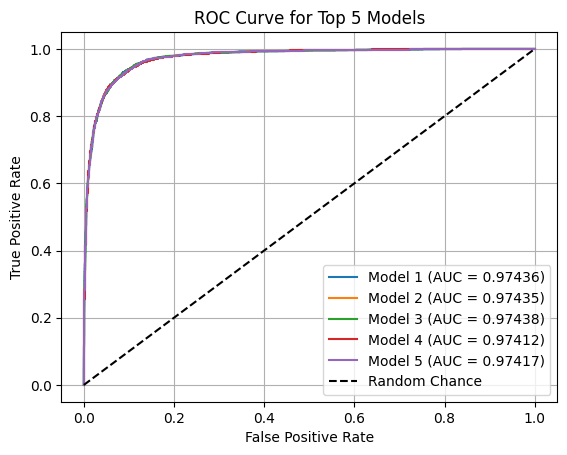

In [140]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming X_val and y_val are your validation features and target
for idx, model in enumerate(top_5_models):
    y_pred_proba = model.predict_proba(X_val)[:, 1]  # Predicted probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Model {idx + 1} (AUC = {roc_auc:.5f})')

# Plot baseline and finalize ROC curve
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Top 5 Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


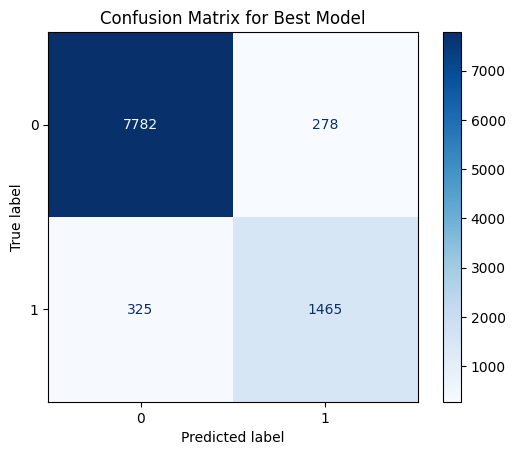

In [150]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the validation set with the best model
best_model = top_5_models[4]
y_pred = best_model.predict(X_val)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix with colors
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best Model")
plt.show()


In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import pandas as pd

# Define parameter search space
search_spaces = {
    'n_estimators': Integer(100, 1000),  # Number of trees
    'max_depth': Integer(2, 400),        # Maximum depth of trees
}

# Initialize the RandomForestClassifier model
model = RandomForestClassifier(random_state=42)

# Use 5-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Use 'accuracy' as the scoring metric
optimizer = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=64,           # Number of parameter sets to try
    cv=kf,                # Cross-validation strategy
    scoring='accuracy',   # Scoring metric
    verbose=1,
    n_jobs=-1,            # Use all available cores
    return_train_score=True
)

# Fit the optimizer using X_train and y_train
optimizer.fit(X_train, y_train)

# Get cross-validation results
cv_results = optimizer.cv_results_

# Create a DataFrame to sort and filter the best models
results_df = pd.DataFrame(cv_results)
top_5_results = results_df.nlargest(5, 'mean_test_score')  # Get top 15 models by mean test score

# Train each of the top 15 models on the full training data and save them
top_5_models = []
for i, row in top_5_results.iterrows():
    params = row['params']
    model = RandomForestClassifier(random_state=42, **params)
    model.fit(X_train, y_train)
    top_5_models.append(model)

# Print parameters and scores for the top 15 models
for idx, model in enumerate(top_5_models):
    print(f"Model {idx + 1} parameters: {top_5_results.iloc[idx]['params']}")
    print(f"Model {idx + 1} CV score: {top_5_results.iloc[idx]['mean_test_score']}")

print("Top 5 Random Forest models based on accuracy have been trained and saved.")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [71]:
# Provided model parameters
model_parameters = [
    {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.17498071644573762, 'max_depth': 2,
     'n_estimators': 500, 'reg_alpha': 0.0, 'reg_lambda': 9.151145867495522, 'subsample': 0.5},
    {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.2549581698910242, 'max_depth': 2,
     'n_estimators': 265, 'reg_alpha': 4.038289521295645, 'reg_lambda': 10.0, 'subsample': 0.9960867858635486},
    {'colsample_bytree': 0.8795506374579873, 'gamma': 0.0, 'learning_rate': 0.30421049078309637, 'max_depth': 2,
     'n_estimators': 486, 'reg_alpha': 0.0, 'reg_lambda': 8.866224462355815, 'subsample': 0.9749930308767123},
    {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.16493489467143477, 'max_depth': 2,
     'n_estimators': 483, 'reg_alpha': 3.3240779723362874, 'reg_lambda': 0.0, 'subsample': 0.5338992950605351},
    {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.15176332186610494, 'max_depth': 2,
     'n_estimators': 500, 'reg_alpha': 6.242954728815679, 'reg_lambda': 10.0, 'subsample': 0.5},
    {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.13040617716396105, 'max_depth': 3,
     'n_estimators': 206, 'reg_alpha': 0.0, 'reg_lambda': 0.10848609573480272, 'subsample': 0.5},
    {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.16770145742460443, 'max_depth': 2,
     'n_estimators': 458, 'reg_alpha': 10.0, 'reg_lambda': 10.0, 'subsample': 0.5},
    {'colsample_bytree': 0.8129503564108058, 'gamma': 0.0, 'learning_rate': 0.15802399297592248, 'max_depth': 2,
     'n_estimators': 500, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.7829437669435633},
    {'colsample_bytree': 0.5472210854922583, 'gamma': 0.36891517213378583, 'learning_rate': 0.2042057552362013,
     'max_depth': 3, 'n_estimators': 477, 'reg_alpha': 9.418738411067523, 'reg_lambda': 9.882994460606403, 'subsample': 0.6009453161350771},
    {'colsample_bytree': 0.5, 'gamma': 3.8813896117418527, 'learning_rate': 0.23171050419161035, 'max_depth': 2,
     'n_estimators': 500, 'reg_alpha': 9.299861755925473, 'reg_lambda': 9.860246011624099, 'subsample': 0.5},
    {'colsample_bytree': 0.5187090871871713, 'gamma': 1.9371693716260263, 'learning_rate': 0.08135956297056286,
     'max_depth': 53, 'n_estimators': 391, 'reg_alpha': 9.572358158935941, 'reg_lambda': 0.3420957950727914, 'subsample': 0.5990142142660962},
    {'colsample_bytree': 0.5375742997971107, 'gamma': 1.4236931028578583, 'learning_rate': 0.17856328866164642,
     'max_depth': 3, 'n_estimators': 221, 'reg_alpha': 4.49220653483089, 'reg_lambda': 7.841135497386919, 'subsample': 0.799031526237848},
    {'colsample_bytree': 0.6558257910115323, 'gamma': 1.7417863837760763, 'learning_rate': 0.05590885653026205,
     'max_depth': 3, 'n_estimators': 435, 'reg_alpha': 9.858087481320169, 'reg_lambda': 0.34221958921542345, 'subsample': 0.9809061058838722},
    {'colsample_bytree': 0.5742198876061808, 'gamma': 2.464551380974906, 'learning_rate': 0.09180938836310773,
     'max_depth': 2, 'n_estimators': 375, 'reg_alpha': 4.614280204189711, 'reg_lambda': 4.688090936618526, 'subsample': 0.9982576387424718},
    {'colsample_bytree': 0.5, 'gamma': 10.0, 'learning_rate': 0.17462497230623591, 'max_depth': 2,
     'n_estimators': 500, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.5}
]

# Initialize arrays to store predictions
train_predictions = []
val_predictions = []
test_predictions = []

# Train models and collect predictions
for idx, params in enumerate(model_parameters, 1):
    print(f"Training Model {idx} with parameters: {params}")

    # Initialize XGBoost model with parameters
    model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='error', **params)

    # Train the model on the meta-train set
    model.fit(X_train, y_train)

    # Predict on train, validation, and test sets
    train_pred = model.predict_proba(X_train)[:, 1]
    train_acc = accuracy_score(y_train, (train_pred > 0.5).astype(int))

    val_pred = model.predict_proba(X_val)[:, 1]
    val_acc = accuracy_score(y_val, (val_pred > 0.5).astype(int))

    test_pred = model.predict_proba(test_set)[:, 1]
    print(f"Train-Val Accuracy: {train_acc}-{val_acc}")
    # Append predictions to the respective arrays
    train_predictions.append(train_pred)
    val_predictions.append(val_pred)
    test_predictions.append(test_pred)

Training Model 1 with parameters: {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.17498071644573762, 'max_depth': 2, 'n_estimators': 500, 'reg_alpha': 0.0, 'reg_lambda': 9.151145867495522, 'subsample': 0.5}
Train-Val Accuracy: 0.9411234237676729-0.9388832487309645
Training Model 2 with parameters: {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.2549581698910242, 'max_depth': 2, 'n_estimators': 265, 'reg_alpha': 4.038289521295645, 'reg_lambda': 10.0, 'subsample': 0.9960867858635486}
Train-Val Accuracy: 0.940703095147115-0.9403045685279188
Training Model 3 with parameters: {'colsample_bytree': 0.8795506374579873, 'gamma': 0.0, 'learning_rate': 0.30421049078309637, 'max_depth': 2, 'n_estimators': 486, 'reg_alpha': 0.0, 'reg_lambda': 8.866224462355815, 'subsample': 0.9749930308767123}
Train-Val Accuracy: 0.9421627818112343-0.939492385786802
Training Model 4 with parameters: {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.16493489467143477, 'max_depth': 2, '

In [ ]:
import numpy as np

# Convert train_predictions (list) to NumPy array
train_predictions_array = np.column_stack(train_predictions)

# Convert train_predictions_array to a DataFrame
train_predictions_df = pd.DataFrame(train_predictions_array, columns=[f"Model_{i+1}" for i in range(train_predictions_array.shape[1])])

# Similarly for val_predictions and test_predictions
val_predictions_array = np.column_stack(val_predictions)
val_predictions_df = pd.DataFrame(val_predictions_array, columns=[f"Model_{i+1}" for i in range(val_predictions_array.shape[1])])

test_predictions_array = np.column_stack(test_predictions)
test_predictions_df = pd.DataFrame(test_predictions_array, columns=[f"Model_{i+1}" for i in range(test_predictions_array.shape[1])])

# Inspect one of the DataFrames
print(train_predictions_df.head())

    Model_1   Model_2   Model_3   Model_4   Model_5   Model_6   Model_7  \
0  0.251242  0.226676  0.199309  0.235344  0.188756  0.174904  0.198623   
1  0.011884  0.007121  0.007199  0.009190  0.006693  0.007105  0.010315   
2  0.084804  0.102299  0.097618  0.118540  0.133718  0.084927  0.134447   
3  0.000767  0.000892  0.000593  0.000648  0.000681  0.001192  0.000824   
4  0.978974  0.978859  0.984682  0.982335  0.977579  0.968099  0.980950   

    Model_8   Model_9  Model_10  Model_11  Model_12  Model_13  Model_14  \
0  0.201382  0.276731  0.207906  0.237120  0.231641  0.181192  0.218942   
1  0.007006  0.006442  0.005668  0.008108  0.007390  0.008129  0.007450   
2  0.076002  0.094696  0.081722  0.100928  0.084072  0.108933  0.105172   
3  0.000711  0.000431  0.000779  0.001496  0.000958  0.001315  0.001490   
4  0.979025  0.986072  0.971625  0.976665  0.973480  0.968814  0.973640   

   Model_15  
0  0.192652  
1  0.007817  
2  0.102633  
3  0.001524  
4  0.969462  


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Train the Logistic Regressor as a meta-model
meta_model = LogisticRegression(max_iter=10000)
meta_model.fit(val_predictions_df, y_val)

# Predict on validation set
meta_val_pred = meta_model.predict(val_predictions_df)

# Evaluate the meta-model
print("Classification Report - Meta Model (Validation Set):")
print(classification_report(y_val, meta_val_pred))
print(f"Validation Accuracy: {accuracy_score(y_val, meta_val_pred):.4f}")

# If test_predictions_array is ready
meta_test_pred = meta_model.predict(test_predictions_df)

from google.colab import files
# Prepare the output DataFrame
output = pd.DataFrame({'id': test_id.values, 'loan_status': meta_test_pred})

# Remove any duplicate rows by 'PassengerId'
output.drop_duplicates(subset='id', keep='first', inplace=True)

# Save predictions to a CSV file
output.to_csv('predictions.csv', index=False)
files.download('predictions.csv')

Classification Report - Meta Model (Validation Set):
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     11513
           1       0.86      0.80      0.83      2557

    accuracy                           0.94     14070
   macro avg       0.91      0.89      0.90     14070
weighted avg       0.94      0.94      0.94     14070

Validation Accuracy: 0.9402


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import classification_report
import xgboost as xgb

params1 = {
    'colsample_bytree': 1.0,
    'gamma': 0.0,
    'learning_rate': 0.14053992185033634,
    'max_depth': 2,
    'n_estimators': 500,
    'reg_alpha': 3.54988240208208,
    'reg_lambda': 0.921308795529119,
    'subsample': 0.5
}
# Define the model with the provided parameters
xgb_model1 = xgb.XGBClassifier(**params1, eval_metric='error')

# Train the model
xgb_model1.fit(val_predictions_df, y_val)

# Predictions on validation set
y_pred_prob_XGB1_val = xgb_model1.predict(val_predictions_df)
print("Classification Report - Validation:")
print(classification_report(y_val, y_pred_prob_XGB1_val))

y_pred_prob_XGB_test = xgb_model1.predict(test_predictions_df)

output = pd.DataFrame({'id': test_id.values, 'loan_status': y_pred_prob_XGB_test})

# Remove any duplicate rows by 'PassengerId'
output.drop_duplicates(subset='id', keep='first', inplace=True)

# Save predictions to a CSV file
output.to_csv('predictions.csv', index=False)
files.download('predictions.csv')

Classification Report - Validation:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     11513
           1       0.87      0.84      0.85      2557

    accuracy                           0.95     14070
   macro avg       0.91      0.91      0.91     14070
weighted avg       0.95      0.95      0.95     14070



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>